In [1]:
import glob
import os
import re
import ast
from datetime import datetime
from tqdm import tqdm
from io import BytesIO
import pandas as pd
import matplotlib.pyplot as plt
from azure.storage.blob import BlobServiceClient

In [2]:
# Storage container config
storage_account_key = "856t0JodjM+g9WGmLKsKtwqFbAgtTONU7MyqgG2WVtzeI9e1bTQsA/yk49zvVxfH3NkG92DG9DVw+AStiIW+/Q=="
storage_account_name = "pqdatawarehouse"
connection_string = "DefaultEndpointsProtocol=https;AccountName=pqdatawarehouse;AccountKey=856t0JodjM+g9WGmLKsKtwqFbAgtTONU7MyqgG2WVtzeI9e1bTQsA/yk49zvVxfH3NkG92DG9DVw+AStiIW+/Q==;EndpointSuffix=core.windows.net"
container_name = "ant-datalake"

blob_service_client = BlobServiceClient.from_connection_string(connection_string)
container_client = blob_service_client.get_container_client(container=container_name)

In [27]:
def get_blobs(prefix):
    "List blobs in the data lake based on prefix pattern"
    blob_list = container_client.list_blobs(name_starts_with=prefix)
    all_blobs = [blob.name for blob in blob_list]
    return all_blobs

def extract_datetime(name):
    """Get datetime from the file name."""
    date_str = name.replace("-PLOT.parquet", "").split(")")[-1]
    return str(datetime.strptime(date_str, '%m %d %Y %H %M'))

def plot(cols, df):
    """Displays a scatter plot of a given column/s"""
    _, ax = plt.subplots(figsize=(8, 8))
    df = df.to_frame().T

    for col in cols:
        series = df[col].apply(ast.literal_eval).explode()
        x_coord = series.apply(lambda x: x[0]).values
        y_coord = series.apply(lambda x: x[1]).values

        if 'Fitted' in col:
            ax.plot(x_coord, y_coord, label=col)
        else:
            ax.scatter(x_coord, y_coord, s=0.5, label=col)
    plt.legend()
    plt.show()

#### Note:

The general data lake structure is as follows:
* <b>Region</b> (Baguio, East Aurora, etc.)
    * <b> Business Unit </b> (CBU, HBU, GBU, etc.)
        * <b> Product </b> (D026-001D, -026-284B, etc.)
            * <b> HNULL </b>
                * <b> Data Type </b>(PLOT, DFQ or RES)
                    * <b>Year</b>
                        * <b>Month</b>
                            * <b>Day</b>
            * <b> MAIN </b>
                * <b> Category </b>(Pre-ATP, Final-ATP, etc.)
                    * <b> Data Type </b> (PLOT, DFQ or RES)
                        * <b> Year</b>
                            * <b> Month</b>
                                * <b> Day</b>


In [31]:
# Sample code to query all D026-001D HNULL plot data 
plot_files = get_blobs(prefix = 'Baguio/CBU/D026-001D/HNULL/PLOTS/2023' )
parquet_files = [file for file in plot_files if "parquet" in file]

In [32]:
print(f"No. of plot data for D026-001D: {len(parquet_files)}")

No. of plot data for D026-001D: 31986


In [30]:
# Download parquet files from the blob to a dataframe without downloading the actual files
results_df = pd.DataFrame()

for file in tqdm(parquet_files[:10]):
    downloaded_blob = container_client.download_blob(file)
    bytes_io = BytesIO(downloaded_blob.readall())
    df = pd.read_parquet(bytes_io)
    df['Serial'] = re.findall(r'\((.*?)\)', file)[0]
    df['Timestamp'] = extract_datetime(file)
    df['Origin'] = os.path.basename(file).replace("-PLOT.parquet",".res")
    results_df = pd.concat([df, results_df])

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.99it/s]


In [17]:
results_df.head()

,Temperature,LandD_Raw,LandC_Raw,LandB_Raw,LandA_Raw,LandD_Fitted,LandC_Fitted,LandB_Fitted,LandA_Fitted,ExpandedFlow_Raw,InternalLeakage_Raw,PressureGain_Raw,DroopPressure_Raw,Serial,Timestamp,Origin
0,35.002075,"((-0.003690633, 2.630093328), (-0.003969644, 2...","((0.007482661, 5.529549233), (0.006822225, 5.0...","((-0.003560859, 2.591367136), (-0.007512455, 5...","((0.006145601, 4.361079759), (0.008062161, 5.6...","((-0.000127892, 0.0), (-0.006622937, 4.8))","((0.000181199, 0.0), (0.006359431, 4.8))","((-0.006465573, 4.8), (-0.000173349, 0.0))","((0.006728911, 4.8), (0.000239047, 0.0))","((1.215003049, -0.01499514), (1.464315712, -0....","((0.079194339, -0.016876091), (0.042563581, -0...","((2951.762068128, -0.02476357), (-2953.4964543...","((0.0, 0.0),)",B104981,2023-01-04 14:34:00,D026-001D H106_T156771(B104981)01 04 2023 14 3...
0,34.466356,"((-0.007203806, 5.498355764), (-0.006898837, 5...","((0.004954746, 3.507982813), (0.007923472, 5.6...","((-0.007074032, 5.193956898), (-0.004095734, 3...","((0.006738572, 4.74318032), (0.004433519, 3.07...","((-0.006594707, 4.8), (-9.0499e-05, 0.0))","((0.006683541, 4.8), (0.000398177, 0.0))","((-0.006468706, 4.8), (-0.000143818, 0.0))","((0.000278701, 0.0), (0.006782204, 4.8))","((-0.168130637, -0.016743356), (0.2115514, -0....","((0.053048002, -0.015137586), (0.066638924, -0...","((-2951.955319745, -0.003599377), (2951.569672...","((0.0, 0.0),)",B104981,2023-01-04 14:19:00,D026-001D H106_T156771(B104981)01 04 2023 14 1...
0,33.834567,"((-0.003659065, 0.668441929), (-0.005537532, 2...","((0.009650698, 5.01263668), (0.005762542, 2.27...","((-0.009359357, 4.970562432), (-0.004891909, 1...","((0.00647154, 2.788549848), (0.009903218, 5.28...","((-0.002740102, 0.0), (-0.009295479, 4.8))","((0.002756353, 0.0), (0.009129545, 4.8))","((-0.009086821, 4.8), (-0.002709655, 0.0))","((0.009196834, 4.8), (0.002697434, 0.0))","((0.0, 0.0),)","((0.0, 0.0),)","((0.0, 0.0),)","((0.0, 0.0),)",B104981,2023-01-04 13:52:00,D026-001D H106_T156771(B104981)01 04 2023 13 5...
0,33.612274,"((-0.006486629, 1.503848821), (-0.006833773, 1...","((0.007777379, 2.282823459), (0.011798268, 5.3...","((-0.013260804, 6.287888442), (-0.005701502, 0...","((0.012342156, 5.819280258), (0.0126141, 6.021...","((-0.010989513, 4.8), (-0.004432094, 0.0))","((0.004697675, 0.0), (0.011132136, 4.8))","((-0.011106008, 4.8), (-0.004641457, 0.0))","((0.004393027, 0.0), (0.010942243, 4.8))","((0.0, 0.0),)","((0.0, 0.0),)","((0.0, 0.0),)","((0.0, 0.0),)",B104981,2023-01-04 13:15:00,D026-001D H106_T156771(B104981)01 04 2023 13 1...
0,31.91278,"((-0.012041809, 5.776156292), (-0.012440862, 5...","((0.011742189, 5.270091127), (0.010537866, 4.3...","((-0.006646479, 1.412290183), (-0.005747798, 0...","((0.010107287, 4.219672383), (0.006678848, 1.7...","((-0.004474883, 0.0), (-0.011013318, 4.8))","((0.011063662, 4.8), (0.004683987, 0.0))","((-0.011117534, 4.8), (-0.004745986, 0.0))","((0.010865156, 4.8), (0.004372824, 0.0))","((0.0, 0.0),)","((0.0, 0.0),)","((0.0, 0.0),)","((0.0, 0.0),)",B104981,2023-01-04 13:05:00,D026-001D H106_T156771(B104981)01 04 2023 13 0...


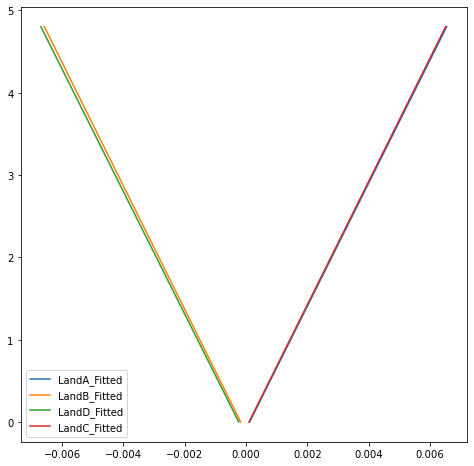

In [24]:
plot([f"Land{i}_Fitted"  for i in 'ABDC'], results_df.iloc[6])

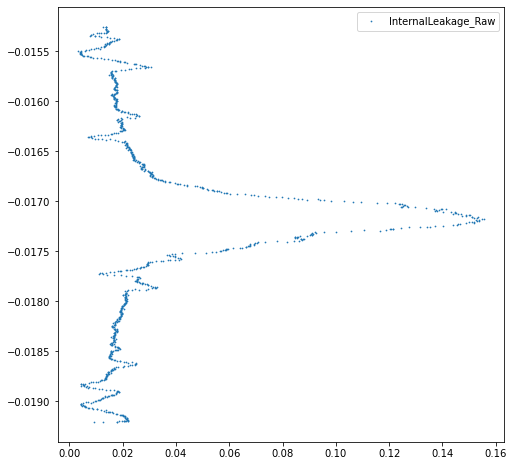

In [18]:
plot(["InternalLeakage_Raw"], results_df.iloc[6])

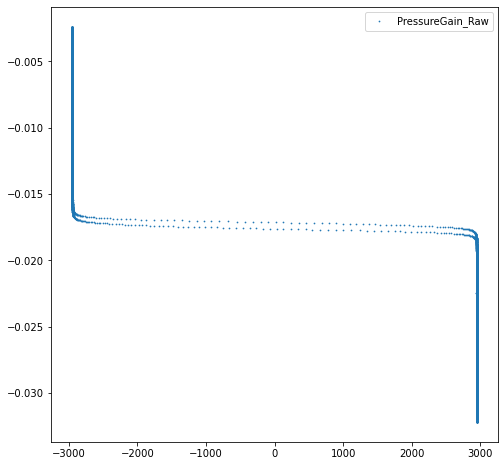

In [26]:
plot(["PressureGain_Raw"], results_df.iloc[6])